In [25]:
import os
import itertools
import random
import copy
import json

import numpy as np

from models import Discriminator, weights_init_normal, GeneratorResNet
from utils import ReplayBuffer, LambdaLR

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

from torch.utils.tensorboard import SummaryWriter

from easydict import EasyDict as edict

import torch
from torch.autograd import Variable
import torch.nn as nn

import sys
sys.path.append("../discogan")
from my_utils import load_dataset, LoaderSampler, tensor2img, get_Z_pushed_loader_stats, calculate_cost
from fid_score import calculate_frechet_distance


batchsize = 1

opt = edict({
    "devices": [1],
    "epoch": 0,
    "n_epochs": 200,
    "decay_epoch": 100,
    
    "batch_size": batchsize,
    "lr": 0.0002,
    "b1": 0.5,
    "b2": 0.999,

    "n_residual_blocks": 9,
    "lambda_cyc": 10.0,
    "lambda_id": 5.0,

    "image_save_interval": (500 * 64) // batchsize,
    "model_save_interval": (500 * 64) // batchsize
})


DATASET1, DATASET1_PATH = 'celeba_female', '../../../../data/img_align_celeba'
DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../../../data/aligned_anime_faces'

IMG_SIZE = 64

filename = 'stats/{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

device = f'cuda:{opt.devices[0]}'
input_shape = (3, IMG_SIZE, IMG_SIZE)

torch.manual_seed(0)
np.random.seed(0)

train_loader_a, test_loader_a = load_dataset(DATASET1, DATASET1_PATH,
                                             img_size=IMG_SIZE, batch_size=32)
train_loader_b, test_loader_b = load_dataset(DATASET2, DATASET2_PATH,
                                             img_size=IMG_SIZE, batch_size=32)

n_batches = min(len(train_loader_a), len(train_loader_b))

X_sampler = LoaderSampler(train_loader_a, device=device)
X_test_sampler = LoaderSampler(test_loader_a, device=device)
Y_sampler = LoaderSampler(train_loader_b, device=device)
Y_test_sampler = LoaderSampler(test_loader_b, device=device)

torch.manual_seed(0)
np.random.seed(0)
X_fixed = X_sampler.sample(12)
Y_fixed = Y_sampler.sample(12)

X_test_fixed = X_test_sampler.sample(12)
Y_test_fixed = Y_test_sampler.sample(12)

lambda = 0.0
lambda = 50.0
lambda = 100.0
lambda = 500.0


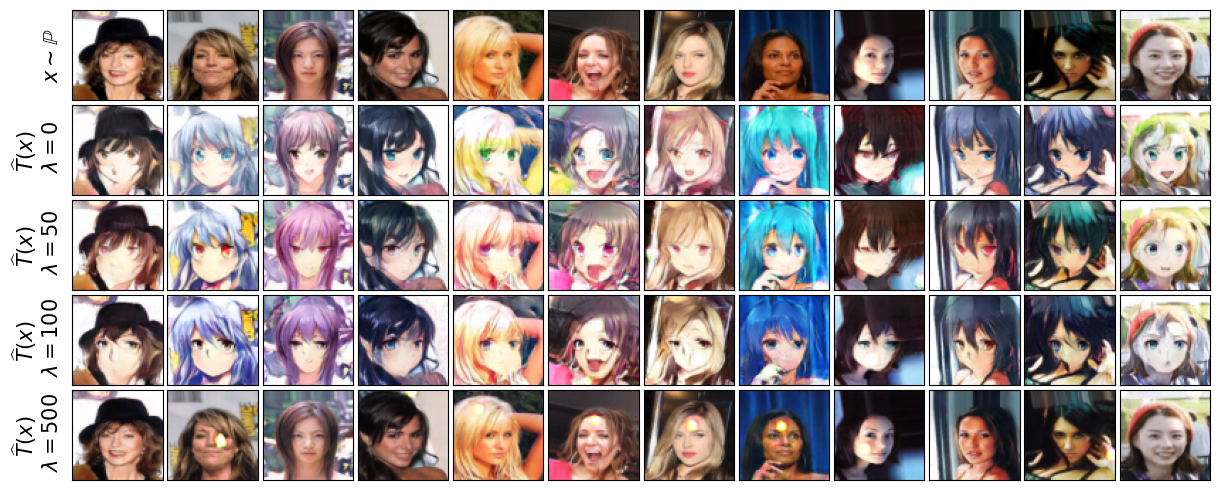

In [10]:
input_shape = (3, IMG_SIZE, IMG_SIZE)

lambda_arr = [0.0, 50.0, 100.0, 500.0]
best_fid_iters = [111000, 131000, 100000, 66000]
best_fid_models = []

base_model_path = '/cache/selikhanovych/extremal_ot/ot/checkpoints/cyclegan_pytorch/celeba_female_aligned_anime_faces_64'

fig, axes = plt.subplots(5, 12, figsize=(12, 5), dpi=100)

for i, lambda_val in enumerate(lambda_arr):
    print(f"lambda = {lambda_val}")
    path_to_model = base_model_path
    if lambda_val != 0.0:
        path_to_model = path_to_model + f'_lambda_{lambda_val}'
    best_iter = best_fid_iters[i]
    path_to_model = os.path.join(path_to_model, 'models', f'model_iter_{best_iter}.pth')
    G_AB = GeneratorResNet(input_shape, opt.n_residual_blocks)
    checkpoint = torch.load(path_to_model)
    G_AB.load_state_dict(checkpoint["netG_A_B"])
    G_AB = G_AB.to(device)
    # mu, sigma = get_Z_pushed_loader_stats(G_AB, X_test_sampler.loader, device)
    # fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
    # print(f"FID = {fid}")
    
    G_AB.eval()

    AB_test = G_AB(X_test_fixed).detach()

    fake_Y_test_numpy = tensor2img(AB_test)
    real_X_test_numpy = tensor2img(X_test_fixed)

    X_tensor = real_X_test_numpy

    for j in range(12):
        axes[0][j].imshow(X_tensor[j])
        axes[0][j].get_xaxis().set_visible(False)
        axes[0][j].set_yticks([])

        axes[i + 1][j].imshow(fake_Y_test_numpy[j])
        axes[i + 1][j].get_xaxis().set_visible(False)
        axes[i + 1][j].set_yticks([])

    axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=15)
    title = r'\widehat{T}(x)'
    axes[i + 1, 0].set_ylabel('${}$ \n $\lambda =${}'.format(title, int(lambda_val)), fontsize=15)

    fig.tight_layout(pad=0.001)    
          
plt.show()

In [6]:
print("a \n b")

a 
 b


In [18]:
indices = [0, 243, 2, 35, 189, 246]
X = torch.stack([test_loader_a.dataset[indices[i]][0].to(device) for i in range(len(indices))])

In [19]:
X.shape

torch.Size([6, 3, 64, 64])

lambda = 0.0
lambda = 50.0
lambda = 100.0
lambda = 200.0


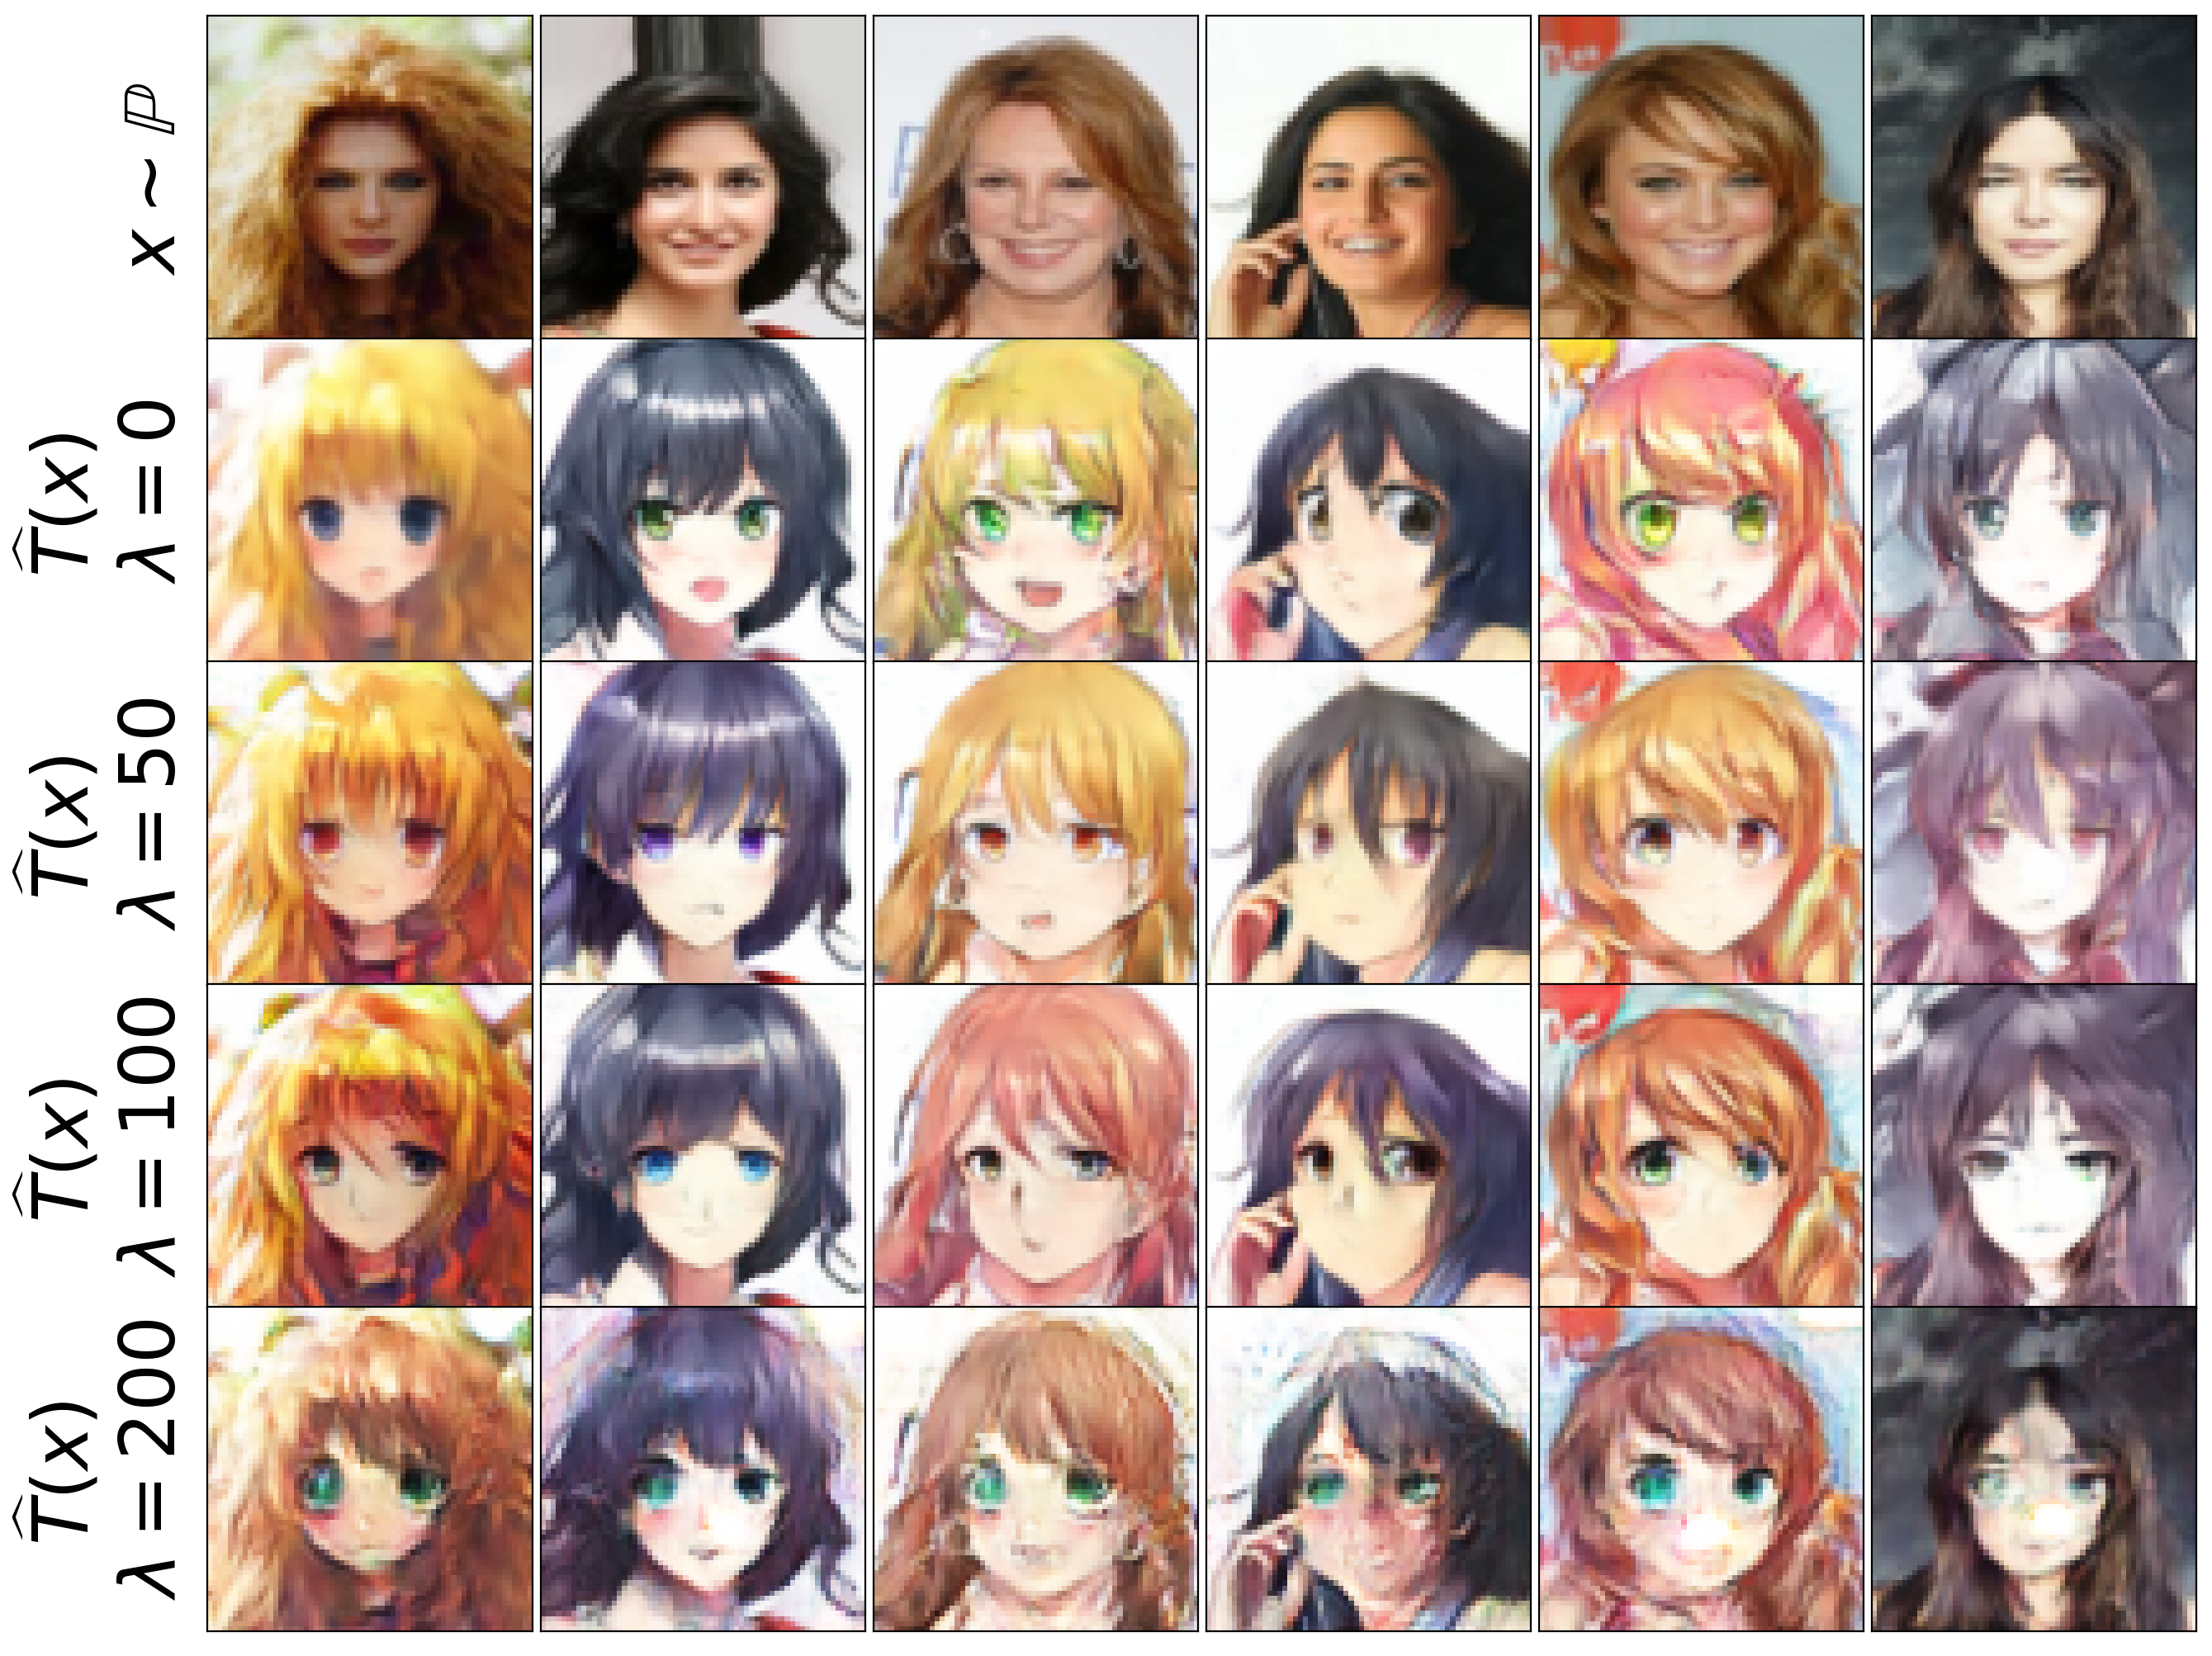

In [30]:
input_shape = (3, IMG_SIZE, IMG_SIZE)

# lambda_arr = [0.0, 50.0, 100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 500.0]
# best_fid_iters = [111000, 131000, 100000, 55000, 15000, 66000, 66000, 66000, 66000]
lambda_arr = [0.0, 50.0, 100.0, 200.0]
best_fid_iters = [111000, 131000, 100000, 15000]
best_fid_models = []

base_model_path = '/cache/selikhanovych/extremal_ot/ot/checkpoints/cyclegan_pytorch/celeba_female_aligned_anime_faces_64'

fig, axes = plt.subplots(1 + len(lambda_arr), len(indices), figsize=(2*len(indices) + 1.2, 2*5), dpi=200)

for i, lambda_val in enumerate(lambda_arr):
    print(f"lambda = {lambda_val}")
    path_to_model = base_model_path
    if lambda_val != 0.0:
        path_to_model = path_to_model + f'_lambda_{lambda_val}'
    best_iter = best_fid_iters[i]
    path_to_model = os.path.join(path_to_model, 'models', f'model_iter_{best_iter}.pth')
    G_AB = GeneratorResNet(input_shape, opt.n_residual_blocks)
    checkpoint = torch.load(path_to_model)
    G_AB.load_state_dict(checkpoint["netG_A_B"])
    G_AB = G_AB.to(device)
    # mu, sigma = get_Z_pushed_loader_stats(G_AB, X_test_sampler.loader, device)
    # fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
    # print(f"FID = {fid}")
    
    # cost = calculate_cost(G_AB, X_test_sampler.loader, device=device, cost_type='mse', verbose=True)
    # print(f"Cost = {cost}")
    
    G_AB.eval()

    AB_test = G_AB(X).detach()

    fake_Y_test_numpy = tensor2img(AB_test)
    real_X_test_numpy = tensor2img(X)

    X_tensor = real_X_test_numpy

    for j in range(len(indices)):
        axes[0][j].imshow(X_tensor[j])
        axes[0][j].get_xaxis().set_visible(False)
        axes[0][j].set_yticks([])

        axes[i + 1][j].imshow(fake_Y_test_numpy[j])
        axes[i + 1][j].get_xaxis().set_visible(False)
        axes[i + 1][j].set_yticks([])

    axes[0, 0].set_ylabel(r'$x\sim\mathbb{P}$', fontsize=33)
    title = r'\widehat{T}(x)'
    axes[i + 1, 0].set_ylabel('${}$ \n $\lambda =${}'.format(title, int(lambda_val)), fontsize=33)

    fig.tight_layout(pad=0.001)    
          
plt.savefig('best_fid_models_cyclegan_celeba2anime_64_all_lambdas.png')
plt.show()